Normalizing Flows  
우리가 갖고있는 데이터의 분포에 어떤 함수를 계속 곱하면 uniform 분포처럼 우리가 아는 쉬운 분포로 변하게 하는 것  
g1 * g2 * g3 * g(x), 단 제약조건이 많다. (1대1 대응 등...)

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

In [2]:
(x_train, _), (x_test, _) = mnist.load_data() # label이 필요하지 않습니다.
x_train = x_train.astype("float32")/255.
x_train = x_train.reshape(-1, 28, 28, 1)
print(x_train.shape)

(60000, 28, 28, 1)


In [3]:
class VAE(Model):
    def __init__(self, latent_dim, beta=1): # beta =1 일반 VAE, kl에서 곱해지는데 regularization의 역할을 함(튀지않게 해주는역할)
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.beta = beta
        
        self.encoder = tf.keras.Sequential(
            [
                 layers.Conv2D(filters=32, kernel_size=3, strides=2, activation='relu', padding='same', input_shape=(28,28,1)),# output : batch_size,14,14,32
                 layers.Conv2D(filters=64, kernel_size=3, strides=2, activation='relu', padding='same'),# output : batch_size,7,7,64
                 layers.Flatten(),# (batch_size, 7*7*64)
                 layers.Dense(latent_dim*2) # (batch_size, 4)
            ]
        )
        # autoencoder는 encoder와 decoder가 만나는 지점이 latent space의 각각의 벡터가 되는데 VAE는 평균과 분산을 가져와서 Z를 만든다.
        
        self.decoder = tf.keras.Sequential(
            [
                layers.Dense(7*7*32, activation='relu'), #batch, 7*7*32 (임의로 설정)
                layers.Reshape((7,7,32)), # batch,7,7,32
                layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu'), # batch, 14, 14, 64 >> 3차원의 tensor가 batch개 있다.
                layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu'), # batch, 28, 28, 32
                layers.Conv2DTranspose(1, 3, strides=1, padding='same', activation='sigmoid') # 28, 28, 1
             ]                                                                                # 원래 x와 recon 비교할 때 pixel wise별로 비교(확률로 나옴)
        )                                                                                     # 활성함수 없으면 with_logit 적용해줘야함

    def encode(self, x):
        mu, logvar = tf.split(self.encoder(x), 2, axis=1)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        epsilon = tf.random.normal(mu.shape) # 같은 차원으로 epsilon을 생성
        sigma = tf.exp(0.5 * logvar) # log(sigma**2) = exp(1/2*log(sigma**2)) = sigma
        return epsilon * sigma + mu # 임의로 생성된 z값 << 이 값이 decoder에 들어감
        # Z = mu + epsilon*sigma

    def generate(self, epsilon=None):
        if epsilon is None:
            epsilon = tf.random.normal((100, self.latent_dim)) # epsilon이 없는 경우 imshow하기 위해 추가함
        return self.decoder(epsilon)
    
    def train_step(self, x):
        if isinstance(x, tuple):
            x = x[0]
        with tf.GradientTape() as tape:
            mu, logvar = self.encode(x)
            z = self.reparameterize(mu, logvar) # random z를 뽑는다.
            x_recon = self.decoder(z) # random z를 recon
            print(x.shape)
            reconstruction_error = tf.reduce_sum(tf.losses.binary_crossentropy(x, x_recon), axis=[1,2]) #x, x_recon 비교 , pixel간 비교는 binary_crossentropy를 쓴다.(MSE해도 될 것 같지만...)
            kl = 0.5*tf.reduce_sum(tf.exp(logvar) + tf.square(mu) -1. -logvar, axis=1) #kl :정확하게 알수있다.
            loss = tf.reduce_mean(self.beta * kl + reconstruction_error)

        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        return {"ELBO": loss, "KL": kl, "RECON": reconstruction_error}

In [4]:
vae = VAE(latent_dim=2, beta=1)

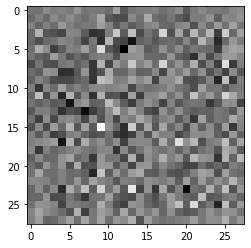

In [5]:
generated_images = vae.generate()
plt.imshow(generated_images[0, :, :, 0], cmap='gray')

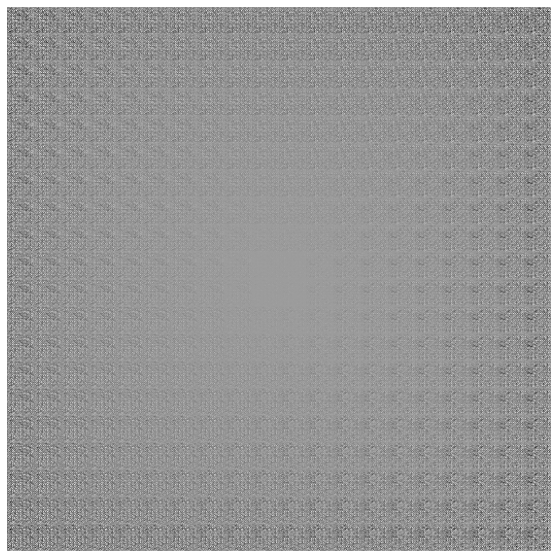

In [8]:
plot_latent_images(vae, 20)

In [10]:
vae.compile(optimizer = tf.keras.optimizers.Adam(1e-4))
vae.fit(x_train, batch_size=100, epochs=200)

Epoch 1/200
(100, 28, 28, 1)
(100, 28, 28, 1)
600/600 [==============================] - 3s 6ms/step - ELBO: 178.6457 - KL: 4.4634 - RECON: 174.1823
Epoch 2/200
600/600 [==============================] - 3s 6ms/step - ELBO: 174.6354 - KL: 4.5716 - RECON: 170.0638
Epoch 3/200
600/600 [==============================] - 3s 6ms/step - ELBO: 172.0042 - KL: 4.5793 - RECON: 167.4249
Epoch 4/200
600/600 [==============================] - 3s 6ms/step - ELBO: 169.6771 - KL: 4.6190 - RECON: 165.0581
Epoch 5/200
600/600 [==============================] - 3s 6ms/step - ELBO: 167.9102 - KL: 4.6935 - RECON: 163.2167
Epoch 6/200
600/600 [==============================] - 3s 6ms/step - ELBO: 166.3860 - KL: 4.7684 - RECON: 161.6176
Epoch 7/200
600/600 [==============================] - 3s 6ms/step - ELBO: 165.1487 - KL: 4.8486 - RECON: 160.3001
Epoch 8/200
600/600 [==============================] - 3s 6ms/step - ELBO: 164.0594 - KL: 4.9168 - RECON: 159.1426
Epoch 9/200
600/600 [=========================

600/600 [==============================] - 3s 6ms/step - ELBO: 151.8603 - KL: 5.9244 - RECON: 145.9359
Epoch 142/200
600/600 [==============================] - 3s 6ms/step - ELBO: 151.8538 - KL: 5.9230 - RECON: 145.9308
Epoch 143/200
600/600 [==============================] - 3s 6ms/step - ELBO: 151.8552 - KL: 5.9198 - RECON: 145.9354
Epoch 144/200
600/600 [==============================] - 3s 6ms/step - ELBO: 151.8147 - KL: 5.9235 - RECON: 145.8913
Epoch 145/200
600/600 [==============================] - 3s 6ms/step - ELBO: 151.7878 - KL: 5.9351 - RECON: 145.8527
Epoch 146/200
600/600 [==============================] - 3s 6ms/step - ELBO: 151.7897 - KL: 5.9340 - RECON: 145.8557
Epoch 147/200
600/600 [==============================] - 3s 6ms/step - ELBO: 151.7648 - KL: 5.9189 - RECON: 145.8459
Epoch 148/200
600/600 [==============================] - 3s 6ms/step - ELBO: 151.7487 - KL: 5.9457 - RECON: 145.8029
Epoch 149/200
600/600 [==============================] - 3s 6ms/step - ELBO: 1

In [47]:
generated_images = vae.generate() # 위의 함수를 보면 무작위로 생성하게 됨 

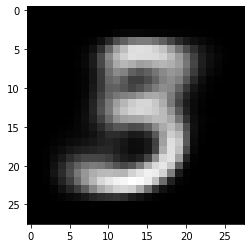

In [48]:
plt.imshow(generated_images[96,:,:,0], cmap='gray') ## 그림 확인 

In [7]:
import tensorflow_probability as tfp

def plot_latent_images(model, n, digit_size=28):
    norm = tfp.distributions.Normal(0, 1)
    grid_x = norm.quantile(np.linspace(0.05, 0.95, n))
    grid_y = norm.quantile(np.linspace(0.05, 0.95, n))
    image_width = digit_size*n
    image_height = image_width
    image = np.zeros((image_height, image_width))

    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z = np.array([[xi, yi]])
            x_decoded = model.generate(z)
            digit = tf.reshape(x_decoded[0], (digit_size, digit_size))
            image[i * digit_size : (i+1)*digit_size, j * digit_size : (j+1) * digit_size] = digit.numpy()
    
    plt.figure(figsize=(10,10))
    plt.imshow(image, cmap='Greys_r')
    plt.axis('Off')
    plt.show()

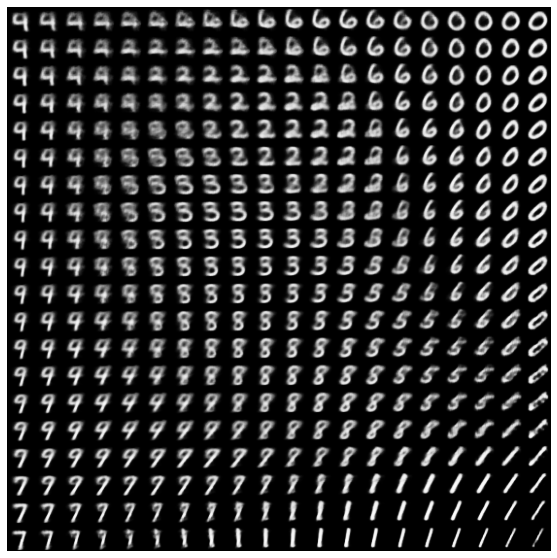

In [50]:
plot_latent_images(vae, 20)

In [55]:
model_beta10 = VAE(latent_dim=2, beta = 10)

In [56]:
model_beta10.compile(optimizer = tf.keras.optimizers.Adam(1e-4))
model_beta10.fit(x_train, batch_size = 100, epochs=30)

Epoch 1/30
(100, 28, 28, 1)
(100, 28, 28, 1)
600/600 [==============================] - 3s 6ms/step - ELBO: 293.4686 - KL: 0.9365 - RECON: 284.1032
Epoch 2/30
600/600 [==============================] - 3s 6ms/step - ELBO: 209.8440 - KL: 0.5959 - RECON: 203.8848
Epoch 3/30
600/600 [==============================] - 3s 6ms/step - ELBO: 203.6390 - KL: 0.7809 - RECON: 195.8302
Epoch 4/30
600/600 [==============================] - 3s 6ms/step - ELBO: 200.0783 - KL: 1.1074 - RECON: 189.0041
Epoch 5/30
600/600 [==============================] - 3s 6ms/step - ELBO: 197.9819 - KL: 1.2653 - RECON: 185.3286
Epoch 6/30
600/600 [==============================] - 3s 6ms/step - ELBO: 196.8744 - KL: 1.3616 - RECON: 183.2584
Epoch 7/30
600/600 [==============================] - 3s 6ms/step - ELBO: 195.9606 - KL: 1.4326 - RECON: 181.6350
Epoch 8/30
600/600 [==============================] - 3s 6ms/step - ELBO: 195.1858 - KL: 1.4976 - RECON: 180.2094
Epoch 9/30
600/600 [==============================] - 

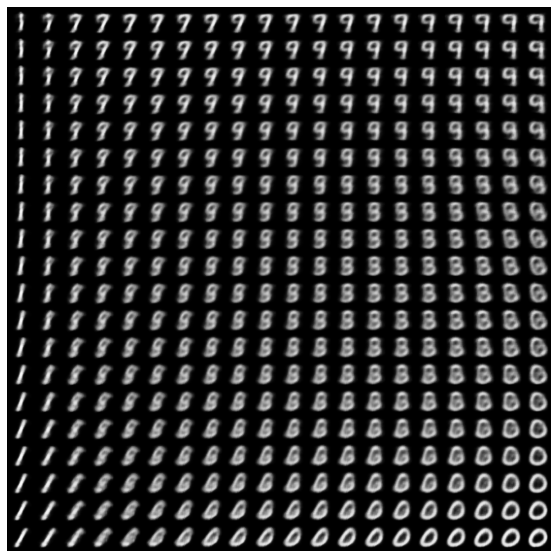

In [57]:
plot_latent_images(model_beta10, 20)

In [62]:
pip freeze

absl-py @ file:///tmp/build/80754af9/absl-py_1615411202722/work
adjustText==0.7.3
aiohttp @ file:///tmp/build/80754af9/aiohttp_1614360992924/work
argon2-cffi @ file:///tmp/build/80754af9/argon2-cffi_1613037097816/work
astunparse==1.6.3
async-generator @ file:///home/ktietz/src/ci/async_generator_1611927993394/work
async-timeout==3.0.1
attrs @ file:///tmp/build/80754af9/attrs_1604765588209/work
backcall @ file:///home/ktietz/src/ci/backcall_1611930011877/work
bleach @ file:///tmp/build/80754af9/bleach_1612211392645/work
blinker==1.4
brotlipy==0.7.0
cachetools @ file:///tmp/build/80754af9/cachetools_1611600262290/work
certifi==2020.12.5
cffi==1.14.0
chardet @ file:///tmp/build/80754af9/chardet_1605303185383/work
click @ file:///home/linux1/recipes/ci/click_1610990599742/work
cloudpickle==1.3.0
coverage @ file:///tmp/build/80754af9/coverage_1614613670853/work
cryptography @ file:///tmp/build/80754af9/cryptography_1616769286105/work
cvxpy==1.1.12
cycler==0.10.0
Cython @ file:///tmp/build/8

In [45]:
tf.version.VERSION

'2.2.0'

In [53]:
!pip install tensorflow-probability==0.9

     |████████████████████████████████| 3.2 MB 1.5 MB/s eta 0:00:01
  Attempting uninstall: tensorflow-probability
    Found existing installation: tensorflow-probability 0.11.0
    Uninstalling tensorflow-probability-0.11.0:
      Successfully uninstalled tensorflow-probability-0.11.0
